# Simulate atmospheric transparency

In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os,sys
import matplotlib as mpl
import pandas as pd
import itertools

from astropy import units as u
from astropy.coordinates import Angle

import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [2]:
from astropy.io import fits

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [4]:
os.getenv('LIBRADTRANDIR')

'/Users/dagoret/MacOSX/External/libRadtran2'

In [5]:
sys.path.append('../libradtran')

In [6]:
import libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


# Initialisation

In [7]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))



LA time: 02:27:15
NY time: 05:27:15
London time: 10:27:15
Paris time: 11:27:15


In [8]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [9]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""
   

In [10]:
msg = f"Start {parser.prog} at date : {string_date} and time :{current_time} and with arguments:{results_args}"
logger.info(msg)

2020-09-12 11:27:15,273 MacBook-Pro-de-admin.local __main__[55057] INFO Start ipykernel_launcher.py at date : 2020-09-12 and time :11:27:15 and with arguments:


# Configuration

In [11]:
# config file
# --------------
configfile = "config/default.ini"
packetnum =100
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)

2020-09-12 11:27:15,285 MacBook-Pro-de-admin.local __main__[55057] INFO Configuration file : config/default.ini


In [12]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-09-12 11:27:15,294 MacBook-Pro-de-admin.local __main__[55057] INFO 1) Configuration


In [13]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)    

In [14]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(config['GENERAL']['FLAG_DEBUG'])
    FLAG_VERBOSE = bool(config['GENERAL']['FLAG_VERBOSE'])
    FLAG_PLOT = bool(config['GENERAL']['FLAG_PLOT'])
    FLAG_PRINT = bool(config['GENERAL']['FLAG_PRINT'])
else:
    msg = f"empty section GENERAL in config file {config_filename} !"
    logger.error(msg)


if 'SIMTRANSPARENCY'in config_section:
    input_file = config['SIMTRANSPARENCY']['inputfile']
    input_dir = config['SIMTRANSPARENCY']['inputdir']

    output_file = config['SIMTRANSPARENCY']['outputfile']
    output_dir = config['SIMTRANSPARENCY']['outputdir']

    packetsize = int(config['SIMTRANSPARENCY']['packetsize'])

full_inputfilename=os.path.join(input_dir,input_file)
full_outputfilename=os.path.join(output_dir,output_file)

In [15]:
msg = f"FLAG_PLOT = {FLAG_PLOT}"
logger.info(msg)


msg=f"input file name = {full_inputfilename}"
logger.info(msg)

msg=f"output file name = {full_outputfilename}"
logger.info(msg)

# range inside the atmospheric parameter file
NROWMIN = (packetnum - 1) * packetsize
NROWMAX = (packetnum) * packetsize - 1

msg = f"NROWMIN = {NROWMIN} , NROWMAX  = {NROWMAX}  "
logger.info(msg)

2020-09-12 11:27:15,335 MacBook-Pro-de-admin.local __main__[55057] INFO FLAG_PLOT = True
2020-09-12 11:27:15,336 MacBook-Pro-de-admin.local __main__[55057] INFO input file name = atmsimdata/atmparam.fits
2020-09-12 11:27:15,338 MacBook-Pro-de-admin.local __main__[55057] INFO output file name = atmsimdata/atmtransparency.fits
2020-09-12 11:27:15,339 MacBook-Pro-de-admin.local __main__[55057] INFO NROWMIN = 9900 , NROWMAX  = 9999  


# open input atmospheric parameters

In [16]:
hduin = fits.open(full_inputfilename)

In [17]:
msg = "{}".format(hduin.info())
logger.info(msg)

Filename: atmsimdata/atmparam.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   (6, 20000)   float64   


2020-09-12 11:27:15,364 MacBook-Pro-de-admin.local __main__[55057] INFO None


In [18]:
headerin=hduin[0].header
datain=hduin[0].data

In [19]:
NSIM=len(datain)

In [20]:
NSIM

20000

In [21]:
if NROWMIN>NSIM:
    msg = f" >>> NROWMIN = {NROWMIN} greater than  NSIM={NSIM} ==> stop simulation"

In [22]:
logger.info(headerin)

2020-09-12 11:27:15,410 MacBook-Pro-de-admin.local __main__[55057] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                    6                                                  NAXIS2  =                20000                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [23]:
logger.info(datain[0,:])

2020-09-12 11:27:15,451 MacBook-Pro-de-admin.local __main__[55057] INFO [  1.           1.16164483   0.18308412   6.31146578 133.31660654
   0.37547343]


In [24]:
hdr=headerin
NSIMH=hdr['NBATMSIM']
idx_num = hdr['ID_NUM']
idx_am = hdr['ID_AM']
idx_vaod=hdr['ID_VAOD']
idx_pwv= hdr['ID_PWV']
idx_o3=hdr['ID_O3']
idx_cld=hdr['ID_CLD']
idx_res= hdr['ID_RES']

In [29]:
for irow in np.arange(min(NROWMIN,NSIM),min(NSIM,NROWMAX)):
    
    am=datain[irow,idx_am ]
    pwv=datain[irow,idx_pwv]
    ozone=datain[irow,idx_o3]
    aer=datain[irow,idx_vaod]
    pressure=0
    cloudext=0

#path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,prof_str='us',proc_str='sa',cloudext=cloudext)
path,thefile=libsimulateVisible.ProcessSimulationaer(am,pwv,ozone,aer,pressure,prof_str='us',proc_str='as',cloudext=cloudext)

data = np.loadtxt(os.path.join(path,thefile))
wl = data[:,0]
atm = data[:,1] 


creazy pressure p= 0  hPa


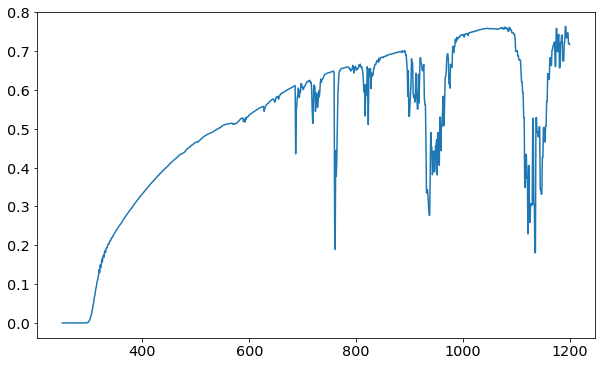

In [30]:
plt.plot(wl,atm)